In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim

import pandas as pd
plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)
FELTOR_PATH="../feltor" # path to the feltor library

In [2]:
# Here we use the Navier-Stokes program and feltordiag with zero timesteps to compute the toroidal averages
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenther.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
                "type" : "blob", # secret init condition in Feltor
                "amplitude" : 4.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "sigma" : 0.05,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "exact-gaussian",
                "sigma_z" : 0.4
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "order" : 2
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-7,
        "atol" : 1e-10,
        "output-mode" : "equidistant",
        "reject-limit"  : 2,
        "Tend" : 1e-4 # choose small we do not simulate anything
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["FCI"]["refine"] = [5,5]
    inputfile["FCI"]["interpolation-method"] = "linear"
    inputfile["advection"]= {
        "type"  : "velocity-staggered",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0.1]
    inputfile["flags"] = []
    inputfile["output"] = {
        "type" : "netcdf",
        "inner_loop" : 1,
        "itstp" : 1,
        "maxout" : 0,
        "compression" : [1,1]
    }
    return inputfile


In [3]:
print(mag.select("guenther.json"))

{'equilibrium': 'guenther', 'description': 'square', 'I_0': 10.0, 'R_0': 3.0, 'comment': 'Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354'}


In [4]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "convoluted-toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
def plot( simfile, name, filename):
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')

    im = ax.pcolormesh(xc, yc, ncin[name][0,:,:],
                          vmin = 0.2, vmax = 0.4,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    plt.savefig( filename,  bbox_inches = 'tight')
    plt.show()
    


In [6]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="Averages/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="Averages/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="Averages/plot", filetype = "nc")


Running simulation ...7707f20e4.nc
Running simulation ...7707f20e4.nc
Averages/data/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


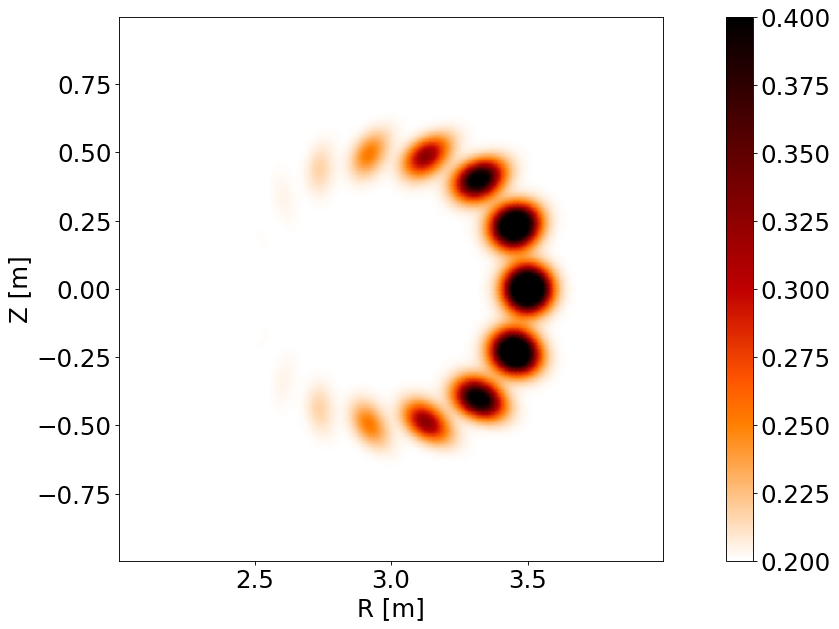

Averages/diag/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


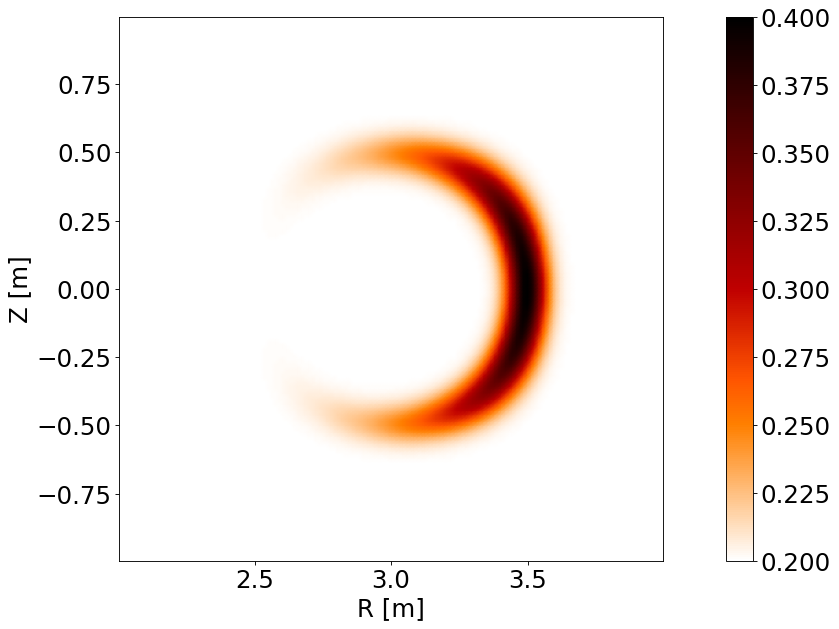

In [7]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error = "display")
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile,  "ions_ta2d", "init-cylinder-ta.png")
plot(diagfile, "ions_cta2d", "init-cylinder-cta10.png")

Running simulation ...8e7eadbaf.nc
Running simulation ...8e7eadbaf.nc
Averages/data/04a00968588f3bf7b91975c53c6f5bc8e7eadbaf.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


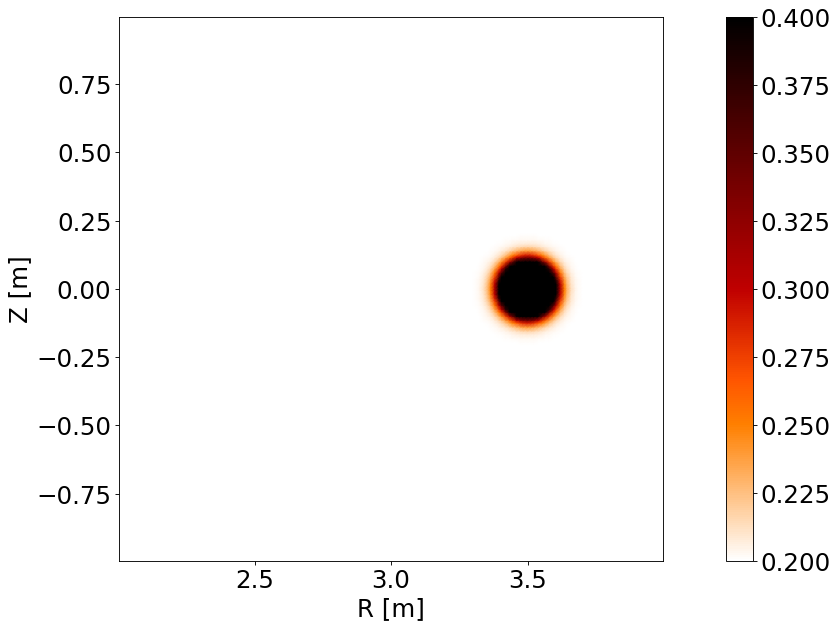

Averages/diag/04a00968588f3bf7b91975c53c6f5bc8e7eadbaf.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


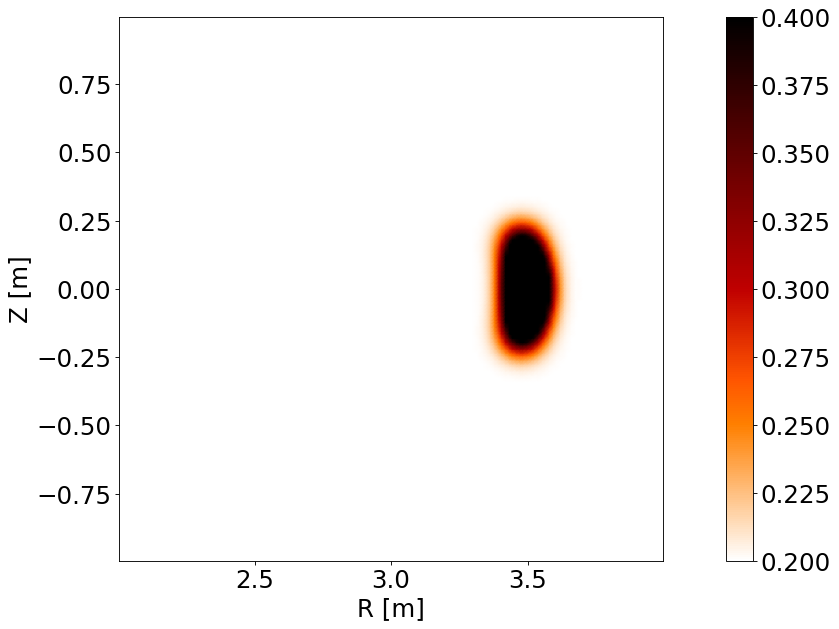

In [8]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"


simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile, "ions_ta2d", "init-toroidal-ta.png")
plot(diagfile, "ions_cta2d", "init-toroidal-cta10.png")

Running simulation ...7707f20e4.nc
Averages/diag/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


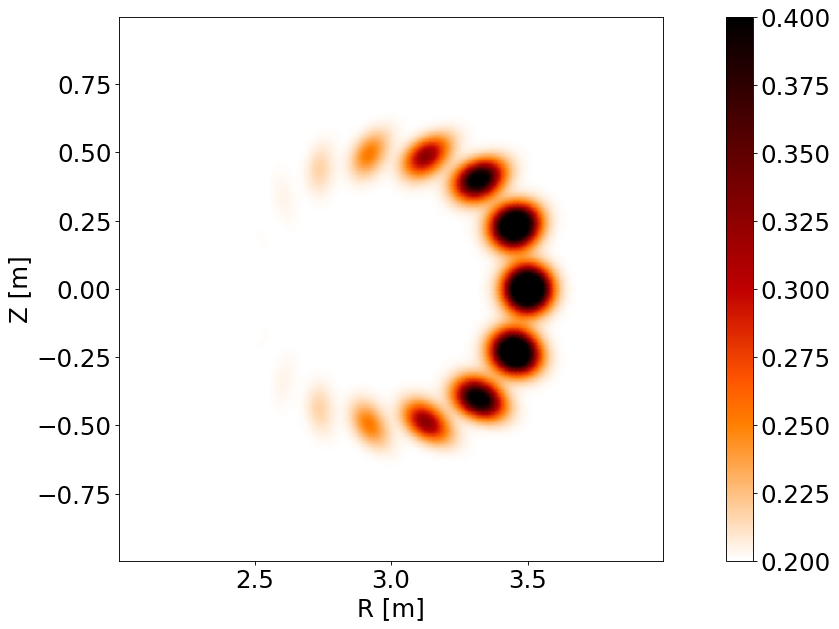

Running simulation ...7707f20e4.nc
Averages/diag/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


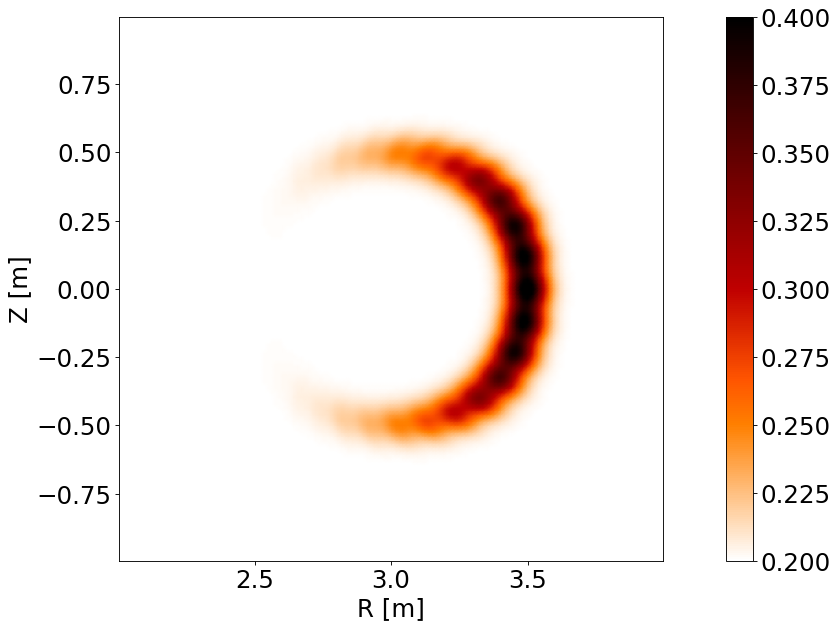

Running simulation ...7707f20e4.nc
Averages/diag/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


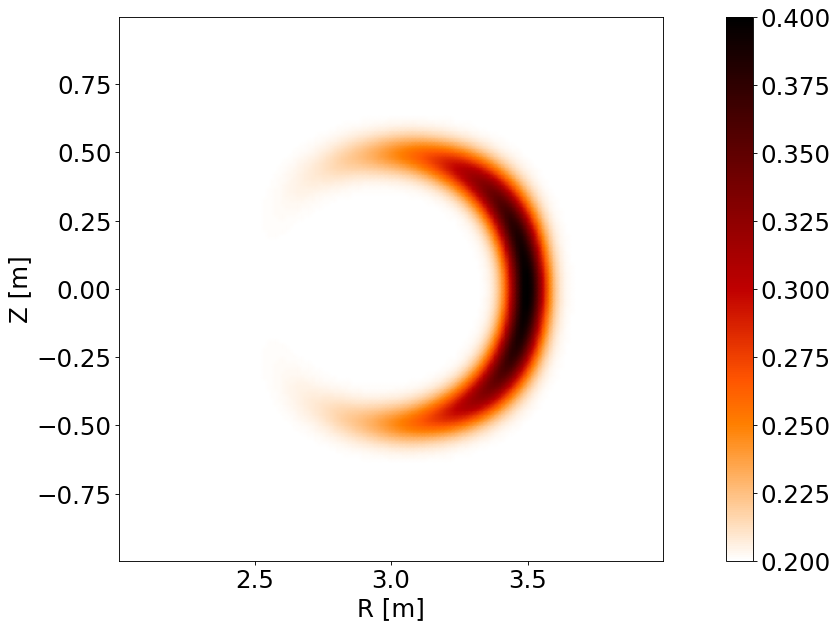

Running simulation ...7707f20e4.nc
Averages/diag/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


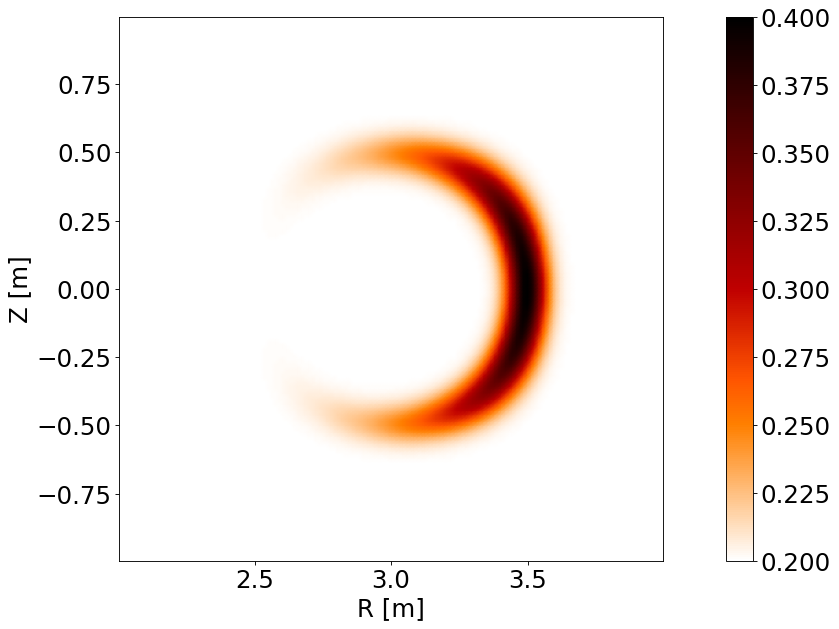

In [9]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

simfile =  simulator.create( simulationfile)

config = create_default_config()
for Kphi in [1,2,5,10]:
    config["Kphi"] = Kphi
    with open( "config.json", 'w') as f:
        json.dump( config, f,
            sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile)

    plot(diagfile, "ions_cta2d", "init-cylinder-cta"+str(Kphi)+".png")

In [10]:
# let us generate a plot file to plot a nice 3d picture in paraview
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 200

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error="display")
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
print(plotfile)
# load plot_init_cylinder_3d statefile in paraview

Running simulation ...65e5a59dd.nc
Running simulation ...65e5a59dd.nc
Running simulation ...65e5a59dd.nc
Averages/plot/71882dd4a7f382afb7a9f18a96528a665e5a59dd.nc


In [11]:
print( "FILE CONTENTS")
ncin = Dataset( diagfile, 'r', format="NETCDF4")
for v in ncin.variables:
#     if v == "time" : 
#         print(f"{v} {ncin.variables[v].shape}")
#     else : 
    print( f"{v} {ncin.variables[v].shape}")
#     ,
#             f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
psi (192,)
dvdpsi (192,)
psi_vol (192,)
psi_area (192,)
rho (192,)
rho_p (192,)
q-profile (192,)
psi_psi (192,)
psit1d (192,)
rho_t (192,)
time (1,)
y (150,)
x (150,)
electrons_fluc2d (1, 150, 150)
electrons_cta2d (1, 150, 150)
electrons_fsa2d (1, 150, 150)
electrons_fsa (1, 192)
electrons_std_fsa (1, 192)
electrons_ifs (1, 192)
electrons_ifs_lcfs (1,)
electrons_ifs_norm (1,)
ions_fluc2d (1, 150, 150)
ions_cta2d (1, 150, 150)
ions_fsa2d (1, 150, 150)
ions_fsa (1, 192)
ions_std_fsa (1, 192)
ions_ifs (1, 192)
ions_ifs_lcfs (1,)
ions_ifs_norm (1,)
Ue_fluc2d (1, 150, 150)
Ue_cta2d (1, 150, 150)
Ue_fsa2d (1, 150, 150)
Ue_fsa (1, 192)
Ue_std_fsa (1, 192)
Ue_ifs (1, 192)
Ue_ifs_lcfs (1,)
Ue_ifs_norm (1,)
Ui_fluc2d (1, 150, 150)
Ui_cta2d (1, 150, 150)
Ui_fsa2d (1, 150, 150)
Ui_fsa (1, 192)
Ui_std_fsa (1, 192)
Ui_ifs (1, 192)
Ui_ifs_lcfs (1,)
Ui_ifs_norm (1,)
potential_fluc2d (1, 150, 150)
potential_cta2d (1, 150, 150)
potential_fsa2d (1, 150, 150)
potential_fsa (1, 192)
potential

divjeipar_tt_fsa2d (1, 150, 150)
divjeipar_tt_fsa (1, 192)
divjeipar_tt_std_fsa (1, 192)
divjeipar_tt_ifs (1, 192)
divjeipar_tt_ifs_lcfs (1,)
divjeipar_tt_ifs_norm (1,)
oexbi_fluc2d (1, 150, 150)
oexbi_cta2d (1, 150, 150)
oexbi_fsa2d (1, 150, 150)
oexbi_fsa (1, 192)
oexbi_std_fsa (1, 192)
oexbi_ifs (1, 192)
oexbi_ifs_lcfs (1,)
oexbi_ifs_norm (1,)
oexbe_fluc2d (1, 150, 150)
oexbe_cta2d (1, 150, 150)
oexbe_fsa2d (1, 150, 150)
oexbe_fsa (1, 192)
oexbe_std_fsa (1, 192)
oexbe_ifs (1, 192)
oexbe_ifs_lcfs (1,)
oexbe_ifs_norm (1,)
odiai_fluc2d (1, 150, 150)
odiai_cta2d (1, 150, 150)
odiai_fsa2d (1, 150, 150)
odiai_fsa (1, 192)
odiai_std_fsa (1, 192)
odiai_ifs (1, 192)
odiai_ifs_lcfs (1,)
odiai_ifs_norm (1,)
odiae_fluc2d (1, 150, 150)
odiae_cta2d (1, 150, 150)
odiae_fsa2d (1, 150, 150)
odiae_fsa (1, 192)
odiae_std_fsa (1, 192)
odiae_ifs (1, 192)
odiae_ifs_lcfs (1,)
odiae_ifs_norm (1,)
jvoexbi_tt_fluc2d (1, 150, 150)
jvoexbi_tt_cta2d (1, 150, 150)
jvoexbi_tt_fsa2d (1, 150, 150)
jvoexbi_tt_fsa (1

In [12]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = 2
    ly = 2
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [13]:
def compare_ta( simfile, bigfile, name1, name2) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    bigg = Dataset( bigfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    weights = gauss_weights( gg)

    num = ncin[name1][0,:,:]-0.2
    sol = bigg[name2][0,:,:]-0.2
    diff = num - sol
    norm_diff = np.sqrt(np.sum( diff[:,:]**2*weights ))
#     norm_diff = np.max(np.abs(diff))
    norm_sol = np.sqrt(np.sum( sol[:,:]**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    return norm_diff/ norm_sol

In [14]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [15]:
# Create one big file
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()

    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
#     lines.append( [Nphi, compare_ta( simfile, bigdiag, "ions_ta2d", "ions_cta2d"),
#                   compare_ta( diagfile, bigdiag, "ions_cta2d", "ions_cta2d")])

df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fieldaligned_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Running simulation ...1692283e5.nc
Running simulation ...1692283e5.nc
Running simulation ...de804761a.nc
Running simulation ...de804761a.nc
Running simulation ...a475b0cd8.nc
Running simulation ...a475b0cd8.nc
Running simulation ...43a028592.nc
Running simulation ...43a028592.nc
Running simulation ...fbcc0ef83.nc
Running simulation ...fbcc0ef83.nc


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}         \
                                                         error  order   
$N_\varphi$                                                             
5                                                     1.32e+00    n/a   
10                                                    6.20e-01   1.09   
20                                                    5.60e-02   3.47   
40                                                    1.06e-05  12.37   
80                                                    1.52e-07   6.12   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.06e-02      n/a  
10                                                    1.76e-02     2.01  
20                                                    4.40e-03     2.00  
40                                                    1.30e-03     1.76  
80                                                    6.88e-04     0.92

In [16]:
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
    #plot_ta(simfile)
df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_toroidal_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Running simulation ...79745e386.nc
Running simulation ...79745e386.nc
Running simulation ...8bffd00f8.nc
Running simulation ...8bffd00f8.nc
Running simulation ...fd3510f09.nc
Running simulation ...fd3510f09.nc
Running simulation ...e87923447.nc
Running simulation ...e87923447.nc
Running simulation ...1c8724bc3.nc
Running simulation ...1c8724bc3.nc


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}        \
                                                         error order   
$N_\varphi$                                                            
5                                                     3.33e-03   n/a   
10                                                    9.02e-04  1.88   
20                                                    2.29e-04  1.98   
40                                                    5.71e-05  2.00   
80                                                    1.39e-05  2.04   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.66e-01      n/a  
10                                                    5.62e-01     0.45  
20                                                    2.83e-01     0.99  
40                                                    9.49e-02     1.58  
80                                                    2.59e-02     1.87

In [17]:
# Construct the Gaussian weights on our grids
def gauss_weights1d( js) :
    n = js["n"]
    Nx = js["Npsi"]
    lx = 1 # length drops out in relative error BUT NOT ABSOLUTE
    hx = lx/Nx
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Npsi"])*hx/2
    return weights1dX

In [18]:
def compare_fsa( simulationfile) :
    config = create_default_config()
    weights = gauss_weights1d( config)[:]
    config["fsa"] = "toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile1 = diagnoser.recreate( simulationfile)
    ncin1 = Dataset( diagfile1, 'r', format="NETCDF4")
    num = ncin1["ions_fsa"][:]
    norm = np.sqrt(np.sum( num[:]**2*weights ))
    print(norm)
    ncin1.close()

    config["fsa"] = "convoluted-toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile2 = diagnoser.recreate( simulationfile)
    ncin2 = Dataset( diagfile2, 'r', format="NETCDF4")  
    sol = ncin2["ions_fsa"][:]
    norm = np.sqrt(np.sum( sol[:]**2*weights ))
    print(norm)
    ncin2.close()
    

    diff = num - sol
    #norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff[:]**2*weights ))
    #norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( sol[:]**2*weights ))

    return norm_diff/ norm_sol

In [19]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesT = list()
for Nphi in [5,10,20,40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesT.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

Averages/data/60b5dad75299d09bff0d8f16fd267de79745e386.nc
Running simulation ...79745e386.nc
0.21184592514925701
Running simulation ...79745e386.nc
0.21162434036099925
Averages/data/04a00968588f3bf7b91975c53c6f5bc8e7eadbaf.nc
Running simulation ...8e7eadbaf.nc
0.2118143799603631
Running simulation ...8e7eadbaf.nc
0.21175770441832054
Averages/data/ee3232eed3970ba2f672a2ff8bf99bdfd3510f09.nc
Running simulation ...fd3510f09.nc
0.21180563235963698
Running simulation ...fd3510f09.nc
0.21179133596765268
Averages/data/0bfac431f38c534a820f37e541d1089e87923447.nc
Running simulation ...e87923447.nc
0.21180339442957385
Running simulation ...e87923447.nc
0.21179972098423458


In [20]:
df = pd.DataFrame(linesT, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f) \rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_toroidal.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

$\langle f - S(f) \rangle$       
                                  error order
$N_\varphi$                                  
5                              2.07e-03   n/a
10                             5.36e-04  1.95
20                             1.51e-04  1.83
40                             3.84e-05  1.97

In [21]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesE = list()
for Nphi in [5,10,20] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesE.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

Averages/data/14d083b7500b785aeb939b3b7d3e3dc1692283e5.nc
Running simulation ...1692283e5.nc
0.21086281975124713
Running simulation ...1692283e5.nc
0.2107262097786049
Averages/data/2b7f0936c4d2dc9a8f6215d2f22f5537707f20e4.nc
Running simulation ...7707f20e4.nc
0.21086282975843362
Running simulation ...7707f20e4.nc
0.2108277905882925
Averages/data/b9d2d0e3fb6defcb4cf7dbd0ae3d557a475b0cd8.nc
Running simulation ...a475b0cd8.nc
0.21086286562768736
Running simulation ...a475b0cd8.nc
0.21085394572583946


In [22]:
df = pd.DataFrame(linesE, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
    np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f)\rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_aligned.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

$\langle f - S(f)\rangle$       
                                 error order
$N_\varphi$                                 
5                             1.29e-03   n/a
10                            3.31e-04  1.96
20                            8.79e-05  1.92

In [23]:
# Here, we create a comparison between the volume integration
lines = list()
for Nphi in [5,10,20,40,80] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    config = create_default_config()
    config["fsa"] = "convoluted-toroidal-average"
    config["Npsi"] = 64
    config["Neta"] = 640
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.create( simulationfile)
    print(diagfile)
    ncin = Dataset( diagfile, 'r', format="NETCDF4")
    num = ncin["ions_ifs_lcfs"][0]
    ana = 24*np.pi/5+0.6841011042693754
    print( num, ana, (num - ana )/ ana)

    lines.append( [Nphi, np.abs(num - ana)/ana])
    #plot_ta(simfile)


Averages/diag/60b5dad75299d09bff0d8f16fd267de79745e386.nc
15.754649915006985 15.763745841500382 -0.0005770155510533218
Averages/diag/04a00968588f3bf7b91975c53c6f5bc8e7eadbaf.nc
15.76167085500675 15.763745841500382 -0.00013163029361773376
Averages/diag/ee3232eed3970ba2f672a2ff8bf99bdfd3510f09.nc
15.763438082930389 15.763745841500382 -1.9523187768198213e-05
Averages/diag/0bfac431f38c534a820f37e541d1089e87923447.nc
15.763877637786429 15.763745841500382 8.360721326752428e-06
Averages/diag/ed7d509681279e72a217cb19b56f1121c8724bc3.nc
15.763995708836179 15.763745841500382 1.5850758969890667e-05


In [24]:
df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.ifs"])
for name  in ["ifs"] :
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])

    df["order."+name] = (np.log( df["order."+name]/ df["order."+name].shift(1))/
     np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\int dV f - \int dV \langle f\rangle$ "]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_ifs.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

$\int dV f - \int dV \langle f\rangle$        
                                              error  order
$N_\varphi$                                               
5                                          5.77e-04    n/a
10                                         1.32e-04   2.13
20                                         1.95e-05   2.75
40                                         8.36e-06   1.22
80                                         1.59e-05  -0.92